# Haystack Test

Build a pipeline that attempts to answer questions by first referencing a corpus of data (dataset will be Seven Wonders of the World) and if no answer is found, it will use a web search to inform the LLM for its response.

In [1]:
!pip install haystack-ai duckduckgo-api-haystack transformers sentence-transformers datasets

  Using cached transformers-4.46.1-py3-none-any.whl.metadata (44 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.9.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached safetensors-0.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached tokenizers-0.20.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.10.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached aiohappyeyeballs-2.4.3-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.5.0-cp311-cp311

## Basic Query of LLM

Using local LLM hosted on OpenAI API compatible endpoint, specifidied by haystack OpenAIGenerator.

In [106]:
client = None

In [107]:
from haystack.components.generators import OpenAIGenerator
from haystack.utils import Secret

LLM_URL = "http://localhost:8000/v1"
LLM_MODEL = "mistralai/Pixtral-12B-2409"

LLM_TOKEN = "myAPIkey"

client = OpenAIGenerator(model=LLM_MODEL, 
                         api_key=Secret.from_token(LLM_TOKEN), 
                         api_base_url=LLM_URL)
response = client.run("What's Natural Language Processing? Be brief.")
print(response)


{'replies': ['Natural Language Processing (NLP) is a subfield of artificial intelligence that focuses on the interaction between computers and humans through natural language. It involves tasks such as text understanding, machine translation, sentiment analysis, and speech recognition, aiming to enable computers to understand, interpret, and generate human language.'], 'meta': [{'model': 'mistralai/Pixtral-12B-2409', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 60, 'prompt_tokens': 12, 'total_tokens': 72, 'completion_tokens_details': None, 'prompt_tokens_details': None}}]}


## Create a Data + Web RAG Pipeline

This uses the "seven wonders of the world" dataset plus web search to find answers to questions.

* Dataset: bilgeyucel/seven-wonders
* Embedding: all-MiniLM-L6-v2

The following:
1. Downloads the seven wonders dataset, embeds those using the all-MiniLM-L6-v2 model into an in-memory doc store.
2. Ceates a generator to connect to a locally hosted openai API LLM.
3. Runs a test query against the LLM

In [108]:
from datasets import load_dataset
from haystack import Document
import torch
from haystack.components.generators import OpenAIGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.utils import Secret

document_store = InMemoryDocumentStore()

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])

generator = client # Use previous OpenAIGenerator

prompt = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>
  What is the capital of France?<|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>"""

generator.run(prompt)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'replies': ['The capital of France is Paris.'],
 'meta': [{'model': 'mistralai/Pixtral-12B-2409',
   'index': 0,
   'finish_reason': 'stop',
   'usage': {'completion_tokens': 8,
    'prompt_tokens': 56,
    'total_tokens': 64,
    'completion_tokens_details': None,
    'prompt_tokens_details': None}}]}

In [109]:
docs[0].content

'The Colossus of Rhodes (Ancient Greek: ὁ Κολοσσὸς Ῥόδιος, romanized:\xa0ho Kolossòs Rhódios Greek: Κολοσσός της Ρόδου, romanized:\xa0Kolossós tes Rhódou)[a] was a statue of the Greek sun-god Helios, erected in the city of Rhodes, on the Greek island of the same name, by Chares of Lindos in 280\xa0BC. One of the Seven Wonders of the Ancient World, it was constructed to celebrate the successful defence of Rhodes city against an attack by Demetrius Poliorcetes, who had besieged it for a year with a large army and navy.\nAccording to most contemporary descriptions, the Colossus stood approximately 70 cubits, or 33 metres (108 feet) high – approximately the height of the modern Statue of Liberty from feet to crown – making it the tallest statue in the ancient world.[2] It collapsed during the earthquake of 226 BC, although parts of it were preserved. In accordance with a certain oracle, the Rhodians did not build it again.[3] John Malalas wrote that Hadrian in his reign re-erected the Colo

In [110]:
doc_embedder

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document]

### RAG Prompt 1

The following creates the RAG prompt for the seven wonders dataset.

In [111]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store, top_k=5)

from haystack.components.builders import PromptBuilder

prompt_template = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Answer the following query given the above documents.
If the answer is not contained within the documents reply with 'no_answer'.
If the answer is contained within the documents, start the answer with "FROM THE KNOWLEDGE BASE: ".

Query: {{query}}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

prompt_builder = PromptBuilder(template=prompt_template)

### Routes

We want to try to get answers from the doc set otherwise go to web.

In [112]:
from haystack.components.routers import ConditionalRouter

routes = [
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

In [113]:
router.run(replies=["this is the answer!"])

{'answer': 'this is the answer!'}

In [114]:
router.run(replies=["no_answer"], query="my query")

{'go_to_websearch': 'my query'}

### Web Search

In [115]:
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

websearch = DuckduckgoApiWebSearch(top_k=5)

In [116]:
# Perform a search
results = websearch.run(query="Where is Tanzania?")

# Access the search results
documents = results["documents"]
links = results["links"]

print("Found documents:")
for doc in documents:
    print(f"Content: {doc.content}")

print("\nSearch Links:")
for link in links:
    print(link)

Found documents:
Content: Tanzania, [b] officially the United Republic of Tanzania, [c] is a country in East Africa within the African Great Lakes region. It is bordered by Uganda to the northwest; Kenya to the northeast; the Indian Ocean to the east; Mozambique and Malawi to the south; Zambia to the southwest; and Rwanda, Burundi, and the Democratic Republic of the ...
Content: Tanzania is situated in East Africa and encompasses an area of approximately 945,087 km 2 (364,900 mi 2).It shares borders with eight countries: Kenya and Uganda to the north, Rwanda, Burundi, and the Democratic Republic of the Congo to the west, and Zambia, Malawi, and Mozambique to the south. The eastern border of Tanzania meets the Indian Ocean.. The East African Rift Valley is one of ...
Content: Tanzania, is an East African country situated just south of the Equator. Tanzania was formed as a sovereign state in 1964 through the union of the theretofore separate states of Tanganyika and Zanzibar.
Content: Po

### RAG Prompt 2 - Websearch

In [117]:
prompt_template_after_websearch = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Answer the following query given the documents retrieved from the web.
Start the answer with "FROM THE WEB: ".

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

prompt_builder_after_websearch = PromptBuilder(template=prompt_template_after_websearch)

## Haystack - Build the Pipeline

In [118]:
from haystack.components.joiners import BranchJoiner
prompt_joiner  = BranchJoiner(str)

from haystack import Pipeline

pipe = Pipeline()
pipe.add_component("text_embedder", text_embedder)
pipe.add_component("retriever", retriever)
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("prompt_joiner", prompt_joiner)
pipe.add_component("llm", generator)
pipe.add_component("router", router)
pipe.add_component("websearch", websearch)
pipe.add_component("prompt_builder_after_websearch", prompt_builder_after_websearch)

pipe.connect("text_embedder", "retriever")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "prompt_joiner")
pipe.connect("prompt_joiner", "llm")
pipe.connect("llm.replies", "router.replies")
pipe.connect("router.go_to_websearch", "websearch.query")
pipe.connect("router.go_to_websearch", "prompt_builder_after_websearch.query")
pipe.connect("websearch.documents", "prompt_builder_after_websearch.documents")
pipe.connect("prompt_builder_after_websearch", "prompt_joiner")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - prompt_joiner: BranchJoiner
  - llm: OpenAIGenerator
  - router: ConditionalRouter
  - websearch: DuckduckgoApiWebSearch
  - prompt_builder_after_websearch: PromptBuilder
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> prompt_joiner.value (str)
  - prompt_joiner.value -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websearch -> prompt_builder_after_websearch.query (str)
  - websearch.documents -> prompt_builder_after_websearch.documents (List[Document])
  - prompt_builder_after_websearch.prompt -> prompt_joiner.value (str)

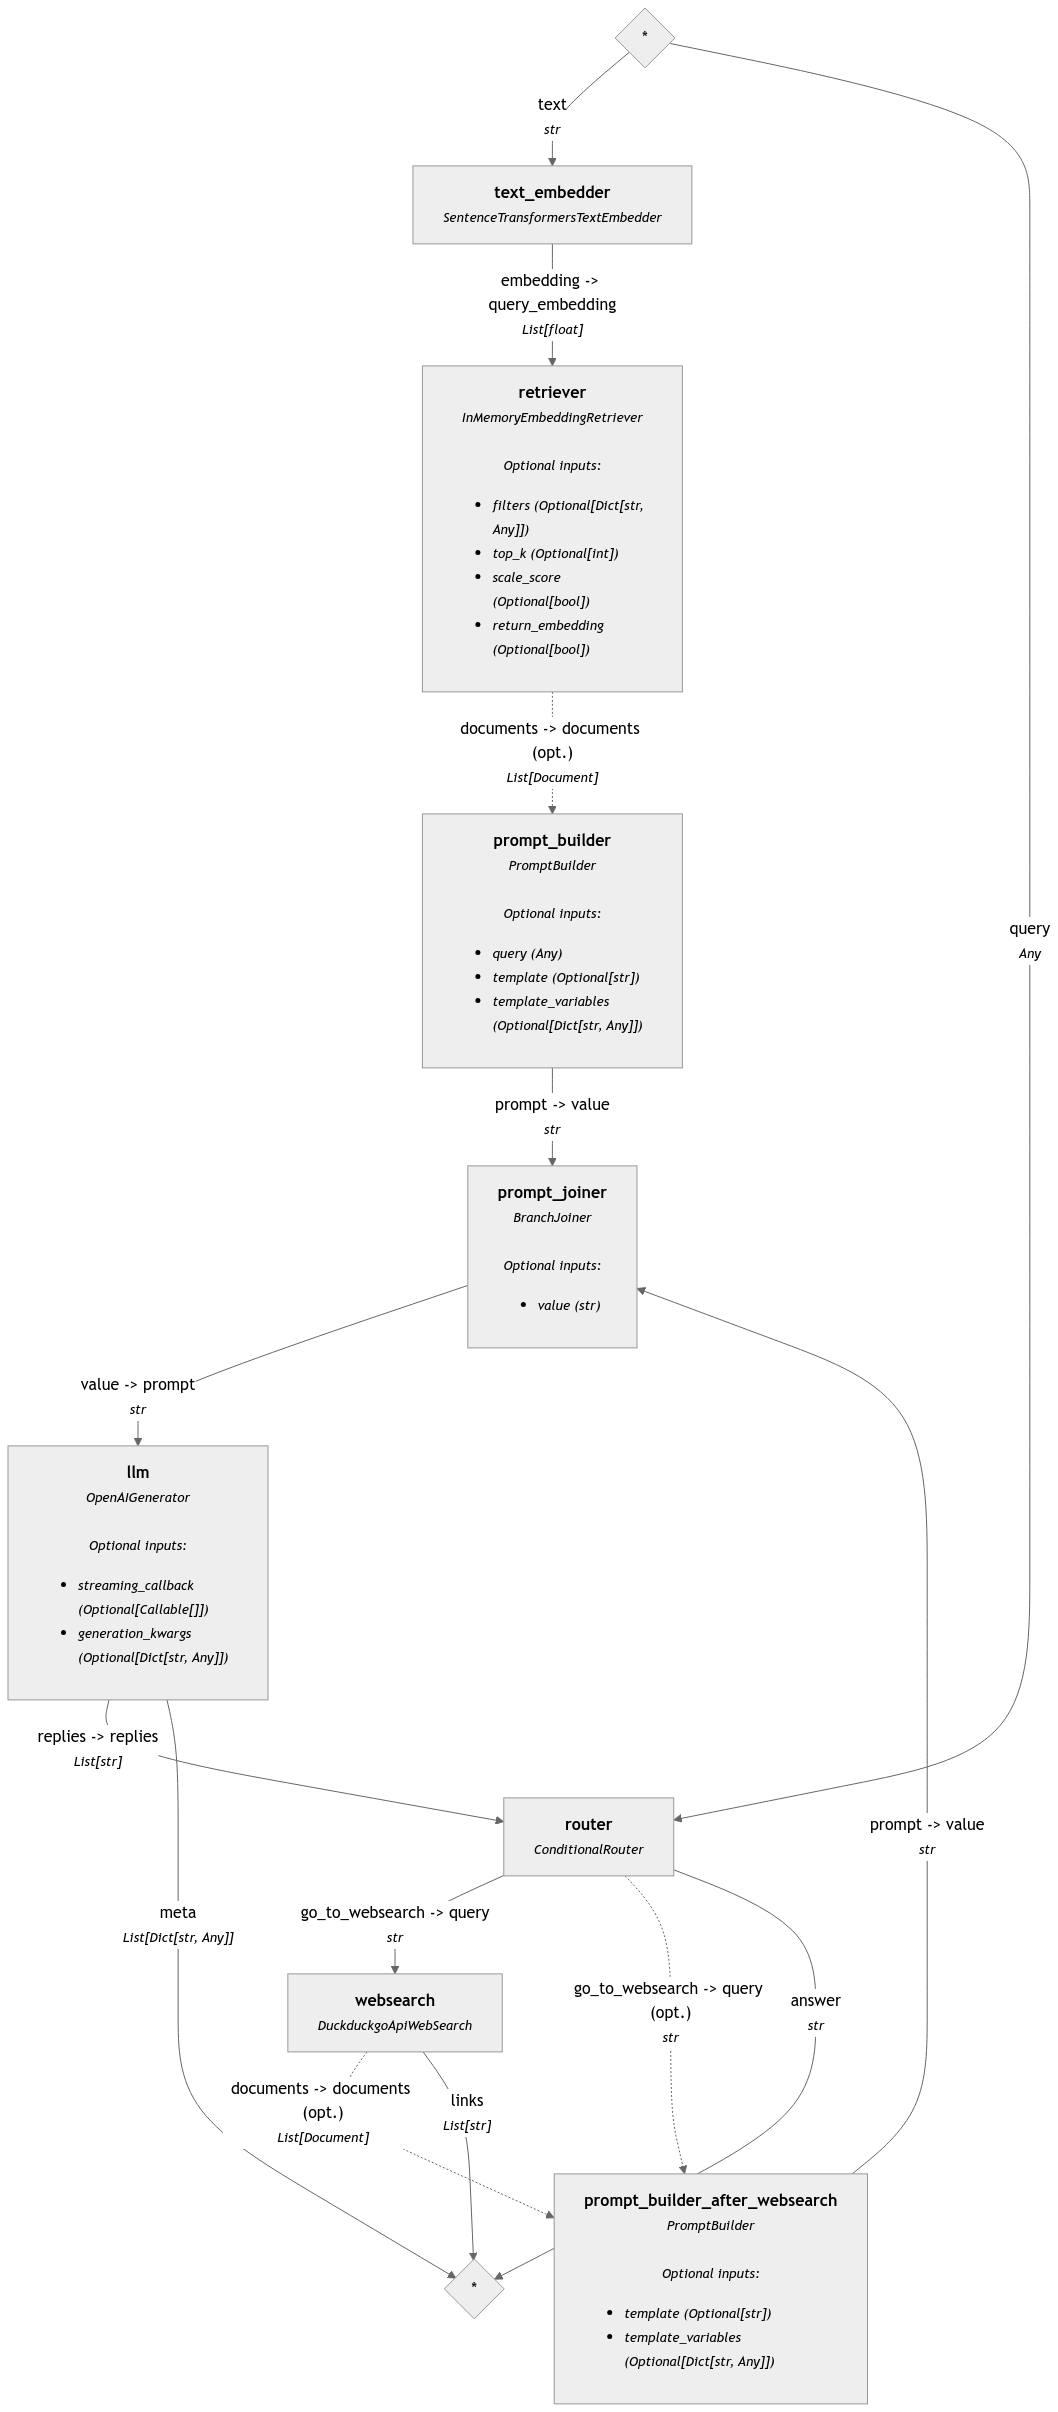

In [119]:
pipe.show()

## Query Examples

In [120]:
def get_answer(query):
  result = pipe.run({"text_embedder": {"text": query}, "prompt_builder": {"query": query}, "router": {"query": query}})
  print(result["router"]["answer"])

In [121]:
get_answer("Why did people build Great Pyramid of Giza?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE KNOWLEDGE BASE:

The Great Pyramid of Giza was built as the tomb of Fourth Dynasty pharaoh Khufu. It was constructed around 2600 BC and served as a grand monument to honor the pharaoh's death and ensure his afterlife. The pyramid's intricate design and precise construction reflect the advanced engineering and architectural capabilities of ancient Egyptian civilization. Additionally, the pyramid played a significant role in the religious and cultural practices of the time, symbolizing the pharaoh's divine status and connection to the gods.


In [122]:
get_answer("Where is London?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE KNOWLEDGE BASE:
London is the capital city of England and the United Kingdom. It is located on the River Thames in the south-east of England.


In [123]:
get_answer("What is backpropagation?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE WEB: Backpropagation is a gradient estimation method commonly used for training neural networks. It efficiently applies the chain rule to neural networks to compute the network parameter updates. Specifically, backpropagation computes the gradient of a loss function with respect to the weights of the network for a single input-output example. This technique is essential for the optimization of artificial neural networks and facilitates the use of gradient descent algorithms to update network weights, enabling deep learning models to "learn." Short for "backward propagation of error," backpropagation was first introduced in the 1960s and popularized in 1989 by Rumelhart, Hinton, and Williams in their paper "Learning representations by back-propagating errors."


In [124]:
get_answer("Was the the Tower of Pisa part of the 7 wonders of the ancient world?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE KNOWLEDGE BASE: No, the Tower of Pisa was not part of the Seven Wonders of the Ancient World. The Seven Wonders of the Ancient World are listed in the provided documents and do not include the Tower of Pisa.


In [126]:
get_answer("What is the Tower of Pisa?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE WEB: The Leaning Tower of Pisa, also known as the Torre Pendente di Pisa, is a freestanding bell tower in the Piazza dei Miracoli ("Square of Miracles") in Pisa, Italy. It is famous for its nearly four-degree lean, which is the result of an unstable foundation. The tower is part of the Pisa Cathedral complex and was designed to be 197 feet (60 meters) tall with eight stories. Construction began in August 1173 and took two centuries to complete. The tower is one of the three structures in the Cathedral Square and is known for its distinctive lean, which was caused by settling during its construction. Extensive work has been done to straighten the tower.


In [125]:
get_answer("Who was general Muawiyah?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

FROM THE KNOWLEDGE BASE:

Muawiyah I was a Muslim general who played a significant role in the early Islamic history. He was the governor of Syria under the caliph Uthman ibn Affan. In 653, he led an Arab force that conquered Rhodes. According to the Chronicle of Theophanes the Confessor, under his command, the statue of the Colossus of Rhodes was completely destroyed and the remains sold; however, the reliability of this account is disputed.
